[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ccc-frankfurt/aisel-hands-on/blob/main/notebooks/NoiseModel.ipynb)


## AISEL -- add  realistic noise effect to images from simulation

Any simulation used in comparison to a estimation pipeline with the real world must embed the propperties of the measurement device. Here we look at a camera as the measurement device.

In this notebook we will add  realistic noise effect to images based on a camera noise model. We follow the blog example at (http://kmdouglass.github.io/posts/modeling-noise-for-image-simulations/ ).

First we import all necessary packages and set camera constants.
These values depend on the camera and in our case we assume an OV2640 CameraChip(tm).
Other cameras will have different values for the constants below.

In [37]:
import glob
import matplotlib.pyplot as plt

import numpy as np
from PIL import Image

# which file we want to process
FILE_ENDING = ".jpg"

# CAMERA CONSTANTS

# the number of always activated sensors for each pixel
# this information was not given, just assumed
BASELINE_CAMERA = 0

# the amount of current per activated sensor
SENSITIVITY_CAMERA = 0.6

# the color depth for each pixel
BIT_DEPTH_CAMERA = 8

# the always active current inside a sensor
DARK_NOISE_CAMERA = 0.015

# the percentage of electrons activating the sensor
# assumed to be the same as the camera in the blog post
QUANTUM_EFFICIENCY_CAMERA = 0.69

We take an 2D array of irradiance values (number of electrons hitting the sensors), simulate a poisson process for the values and add the dark current noise.

In [38]:
# Function to add camera noise
def add_camera_noise(input_irrad_photons,
                     qe=QUANTUM_EFFICIENCY_CAMERA,
                     sensitivity=SENSITIVITY_CAMERA,
                     dark_noise=DARK_NOISE_CAMERA,
                     bitdepth=BIT_DEPTH_CAMERA,
                     baseline=BASELINE_CAMERA,
                     rs=np.random.RandomState(seed=1234)):

    # Add shot noise
    # For each pixel, simulate a poission distribution
    photons = rs.poisson(input_irrad_photons, size=input_irrad_photons.shape)

    # Convert to electrons, since only a percentage of electrons activate the sensors
    electrons = qe * photons

    # simulate a normal distributed dark current centered around 0 for each pixel
    dark_current = rs.normal(scale=dark_noise, size=electrons.shape)

    # add both together to get the number of electrons per pixel
    electrons_out = dark_current + electrons

    max_adu = np.int(2 ** bitdepth - 1)

    # each electron
    adu = (electrons_out * sensitivity).astype(np.int)
    adu += baseline
    adu[adu > max_adu] = max_adu  # models pixel saturation

    return adu

Now we apply the function above to our images. We also need some helper functions to convert images from PNG.


In [39]:
def convert_from_image_file(file_path):
    image = Image.open(file_path)
    pixels = list(image.getdata())
    width, height = image.size
    pixels = np.array([pixels[i * width:(i + 1) * width] for i in range(height)])
    return pixels

def add_noise_to_image(file_path):
    # If other image formats are used write a similar function to convert the image
    # from file to a 2D array with RGB color values
    pixel_data = convert_from_image_file(file_path)

    # calculate number of electrons hitting the sensor and apply noise model
    number_of_electrons_per_pixel = pixel_data / QUANTUM_EFFICIENCY_CAMERA / SENSITIVITY_CAMERA
    pixel_data_noisy = add_camera_noise(number_of_electrons_per_pixel)

    # save the clean and the noisy image as PNG next to the original version
    fig,ax = plt.subplots(1, 2, figsize=(10, 10))
    ax[0].imshow(pixel_data)
    ax[0].set_title("Original image")
    ax[1].imshow(pixel_data_noisy)
    ax[1].set_title("Image after adding noise")
    plt.tight_layout()
    fig.canvas.draw()



START
END


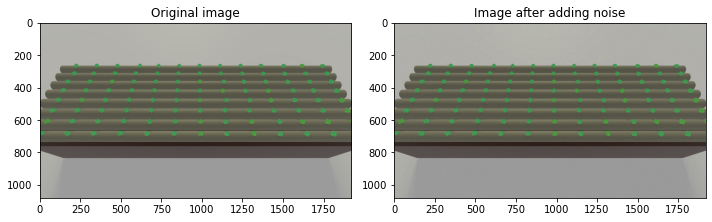

In [40]:
print("START")
# we take every image in the data directory ending with the right and apply our noise model
for file in glob.glob(f"../data/*{FILE_ENDING}"):
    add_noise_to_image(file_path=file)
print("END")